In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from datasets import load_dataset 
import matplotlib.pyplot as plt
#import nltk
#nltk.download('wordnet')
import numpy as np 
import torch
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import davies_bouldin_score
import networkx as nx
import pandas as pd
import collections


#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')

def get_dataset(dataset_name, dataset_info_list):
    if isinstance(dataset_name,list):
        if dataset_name[0] == "tasksource/mmlu":
            try:
                traindata = load_dataset(dataset_name[0],dataset_name[1], split="test[0:100]", num_proc=8) 
            except:
                traindata = load_dataset(dataset_name[0],dataset_name[1], split="test", num_proc=8) 
        elif dataset_name[0] == "tasksource/bigbench":
            try:
                traindata = load_dataset(dataset_name[0],dataset_name[1], split="train[0:100]", num_proc=8) 
            except:
                traindata = load_dataset(dataset_name[0],dataset_name[1], split="train", num_proc=8) 
    else:
        if dataset_name == "EleutherAI/truthful_qa_mc":
            traindata = load_dataset(dataset_name, split="validation[0:100]", num_proc=8) 
        else:
            traindata = load_dataset(dataset_name, split="train[0:100]", num_proc=8) 
    if isinstance(dataset_name,list):
        key = dataset_info_list[dataset_name[0]]["keys"]
    else:
        key = dataset_info_list[dataset_name]["keys"]
    return traindata[key[0]]

def set_random_seed(seed=0):
    #random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_dataset_list(dataset_list):
    dataname = []
    for data in dataset_list:
        if "subset" not in dataset_list[data].keys():
            dataname.append(data)
        else:
            for subset in dataset_list[data]["subset"]:
                dataname.append([data,subset])
    return dataname

set_random_seed()

/home/bhandk/miniconda3/envs/MLNeuron/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
with open("/home/bhandk/MLNeuron/dataset_info.json", 'r') as openfile:
    # Reading from json file
    dataset_info_list = json.load(openfile)
dataset_name_list = get_dataset_list(dataset_info_list)
questions = []
questions_name = []
for dataset_name in dataset_name_list:
    data = get_dataset(dataset_name, dataset_info_list)
    questions.append(" ".join(data))
    if len(dataset_name) == 2:
        questions_name.append(dataset_name[-1])
    else:
        questions_name.append(dataset_name)

# Prepare Corpus and Dictionary

In [3]:

def tokenize_text(text):
    # Tokenize using NLTK
    punctuations = [".","?",";",",",":","`","'","\n","~","_","→","``","''"]
    for punct in punctuations:
        text = text.replace(punct, "")
    tokens = word_tokenize(text)
    # Remove stopwords and perform stemming
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [ps.stem(token) for token in tokens if token.isalnum() not in stop_words]
    #tokens = [token for token in tokens if token.isalnum() not in stop_words]
    return tokens

In [4]:
#tokenizer = RegexpTokenizer(r'\w+')
import copy

new_copy = copy.deepcopy(questions)
for idx in range(len(questions)):
    new_copy[idx] = new_copy[idx].lower()  
    #new_copy[idx] = tokenizer.tokenize(new_copy[idx])  
    new_copy[idx] = tokenize_text(new_copy[idx])
# Remove numbers, but not words that contain numbers.
#questions = [[token for token in q if not token.isnumeric()] for q in questions]

# Remove words that are only one character.
#questions = [[token for token in q if len(token) > 1] for q in questions]

bigram = Phrases(new_copy, min_count=50)
for idx in range(len(new_copy)):
    for token in bigram[new_copy[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            new_copy[idx].append(token)

# Create a dictionary representation of the documents.
dictionary = Dictionary(new_copy)

# Filter out words that occur less than 20 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=1, no_above=0.5)
corpus = [dictionary.doc2bow(q) for q in new_copy]

# Word Network

In [5]:
for i in range(len(corpus)):
    if len(corpus[i])==0:
        print(None)
        print(i,questions_name[i], corpus[i])
        continue

    max_key = sorted(corpus[i], key=lambda k: k[1], reverse=True)
    value = [dictionary[key[0]] for key in max_key[0:10]]
    frequency = [key[1] for key in max_key[0:10]]
    print(i,questions_name[i], value, frequency)

0 commonsense_qa ['he', 'where', 'would', 'hi', 'peopl', 'had', 'want', 'she', 'get', 'person'] [32, 27, 15, 10, 10, 9, 9, 8, 7, 7]
1 abstract_narrative_understanding ['narr', 'proverb', 'illustr', 'he', 'hi', 'she', 'we', 'each', 'good', 'provid'] [301, 201, 200, 167, 121, 112, 107, 105, 105, 101]
2 anachronisms ['contain', '(_anachronist', 'anachronist', 'contain_non-contemporan', 'element', 'non-contemporan', 'preced', 'preced_sentenc', 'sentenc', 'hi'] [100, 100, 100, 100, 100, 100, 100, 100, 100, 16]
3 analogical_similarity ['similar', 'child', 'parent', '-', '<', '>', 'an_exampl', 'episod', 'exampl', 'compel'] [3200, 1406, 1402, 1400, 1400, 1400, 1400, 1400, 1400, 1355]
4 analytic_entailment ['relat', 'determin', 'pair', 'whether', 'sentenc', 'determin_whether', 'embodi', 'entail', 'notsent', 'so'] [55, 54, 54, 54, 54, 54, 54, 54, 54, 42]
5 arithmetic ['choic', 'q', 'banana', 'plu', 'hous', '2', '1', '4', '6', '5'] [629, 100, 94, 80, 65, 52, 43, 42, 42, 40]
6 authorship_verificat

# Create Network

In [97]:
#Nodes = tokens
#Edges = Common tokens between different datasets
filter = 50 #just get top 50
edges = []
G =nx.Graph()
for node_i in range(0,len(corpus)):
    get_node_i = corpus[node_i]
    if filter != None:
        get_node_i = sorted(get_node_i,key=lambda x: x[1], reverse=True)[0:filter]
        get_node_i = [key[0] for key in get_node_i]
    for node_j in range(node_i+1, len(corpus)):
        get_node_j = corpus[node_j]   
        if filter != None:
            get_node_j = sorted(get_node_j,key=lambda x: x[1], reverse=True)#[0:filter]
            get_node_j = [key[0] for key in get_node_j]
        common = list(set(get_node_i).intersection(get_node_j))
        #if len(common) == 0:
        #    continue
        if len(common) >= 5:
            G.add_edge(questions_name[node_i], questions_name[node_j], weight=len(common))


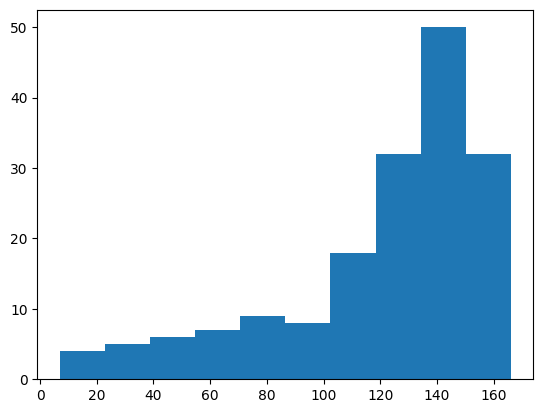

In [98]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

#G.remove_edges_from(nx.selfloop_edges(G))
nx.write_edgelist(G, "network_words.txt")
plot_degree_dist(G)
def dumper(obj):
    try:
        return obj.toJSON()
    except:
        return obj.__dict__

# Serialize data into file:
json_object = json.dumps(dictionary, default=dumper)
# Writing to sample.json
with open("dictionary_words.json", "w") as outfile:
    outfile.write(json_object)

## Open Network

In [99]:
fh = open("network_words.txt", "rb")
G_new = nx.read_edgelist(fh)
fh.close()
print(G_new.nodes())

['commonsense_qa', 'abstract_narrative_understanding', 'anachronisms', 'analogical_similarity', 'analytic_entailment', 'authorship_verification', 'bbq_lite_json', 'causal_judgment', 'cause_and_effect', 'conceptual_combinations', 'crass_ai', 'dark_humor_detection', 'date_understanding', 'disambiguation_qa', 'discourse_marker_prediction', 'emoji_movie', 'empirical_judgments', 'english_proverbs', 'english_russian_proverbs', 'entailed_polarity', 'epistemic_reasoning', 'evaluating_information_essentiality', 'fact_checker', 'fantasy_reasoning', 'figure_of_speech_detection', 'formal_fallacies_syllogisms_negation', 'general_knowledge', 'goal_step_wikihow', 'gre_reading_comprehension', 'hhh_alignment', 'hindu_knowledge', 'hinglish_toxicity', 'identify_odd_metaphor', 'implicatures', 'implicit_relations', 'intent_recognition', 'irony_identification', 'known_unknowns', 'logic_grid_puzzle', 'logical_args', 'logical_fallacy_detection', 'mathematical_induction', 'metaphor_boolean', 'metaphor_understa

Graph with 171 nodes and 10343 edges


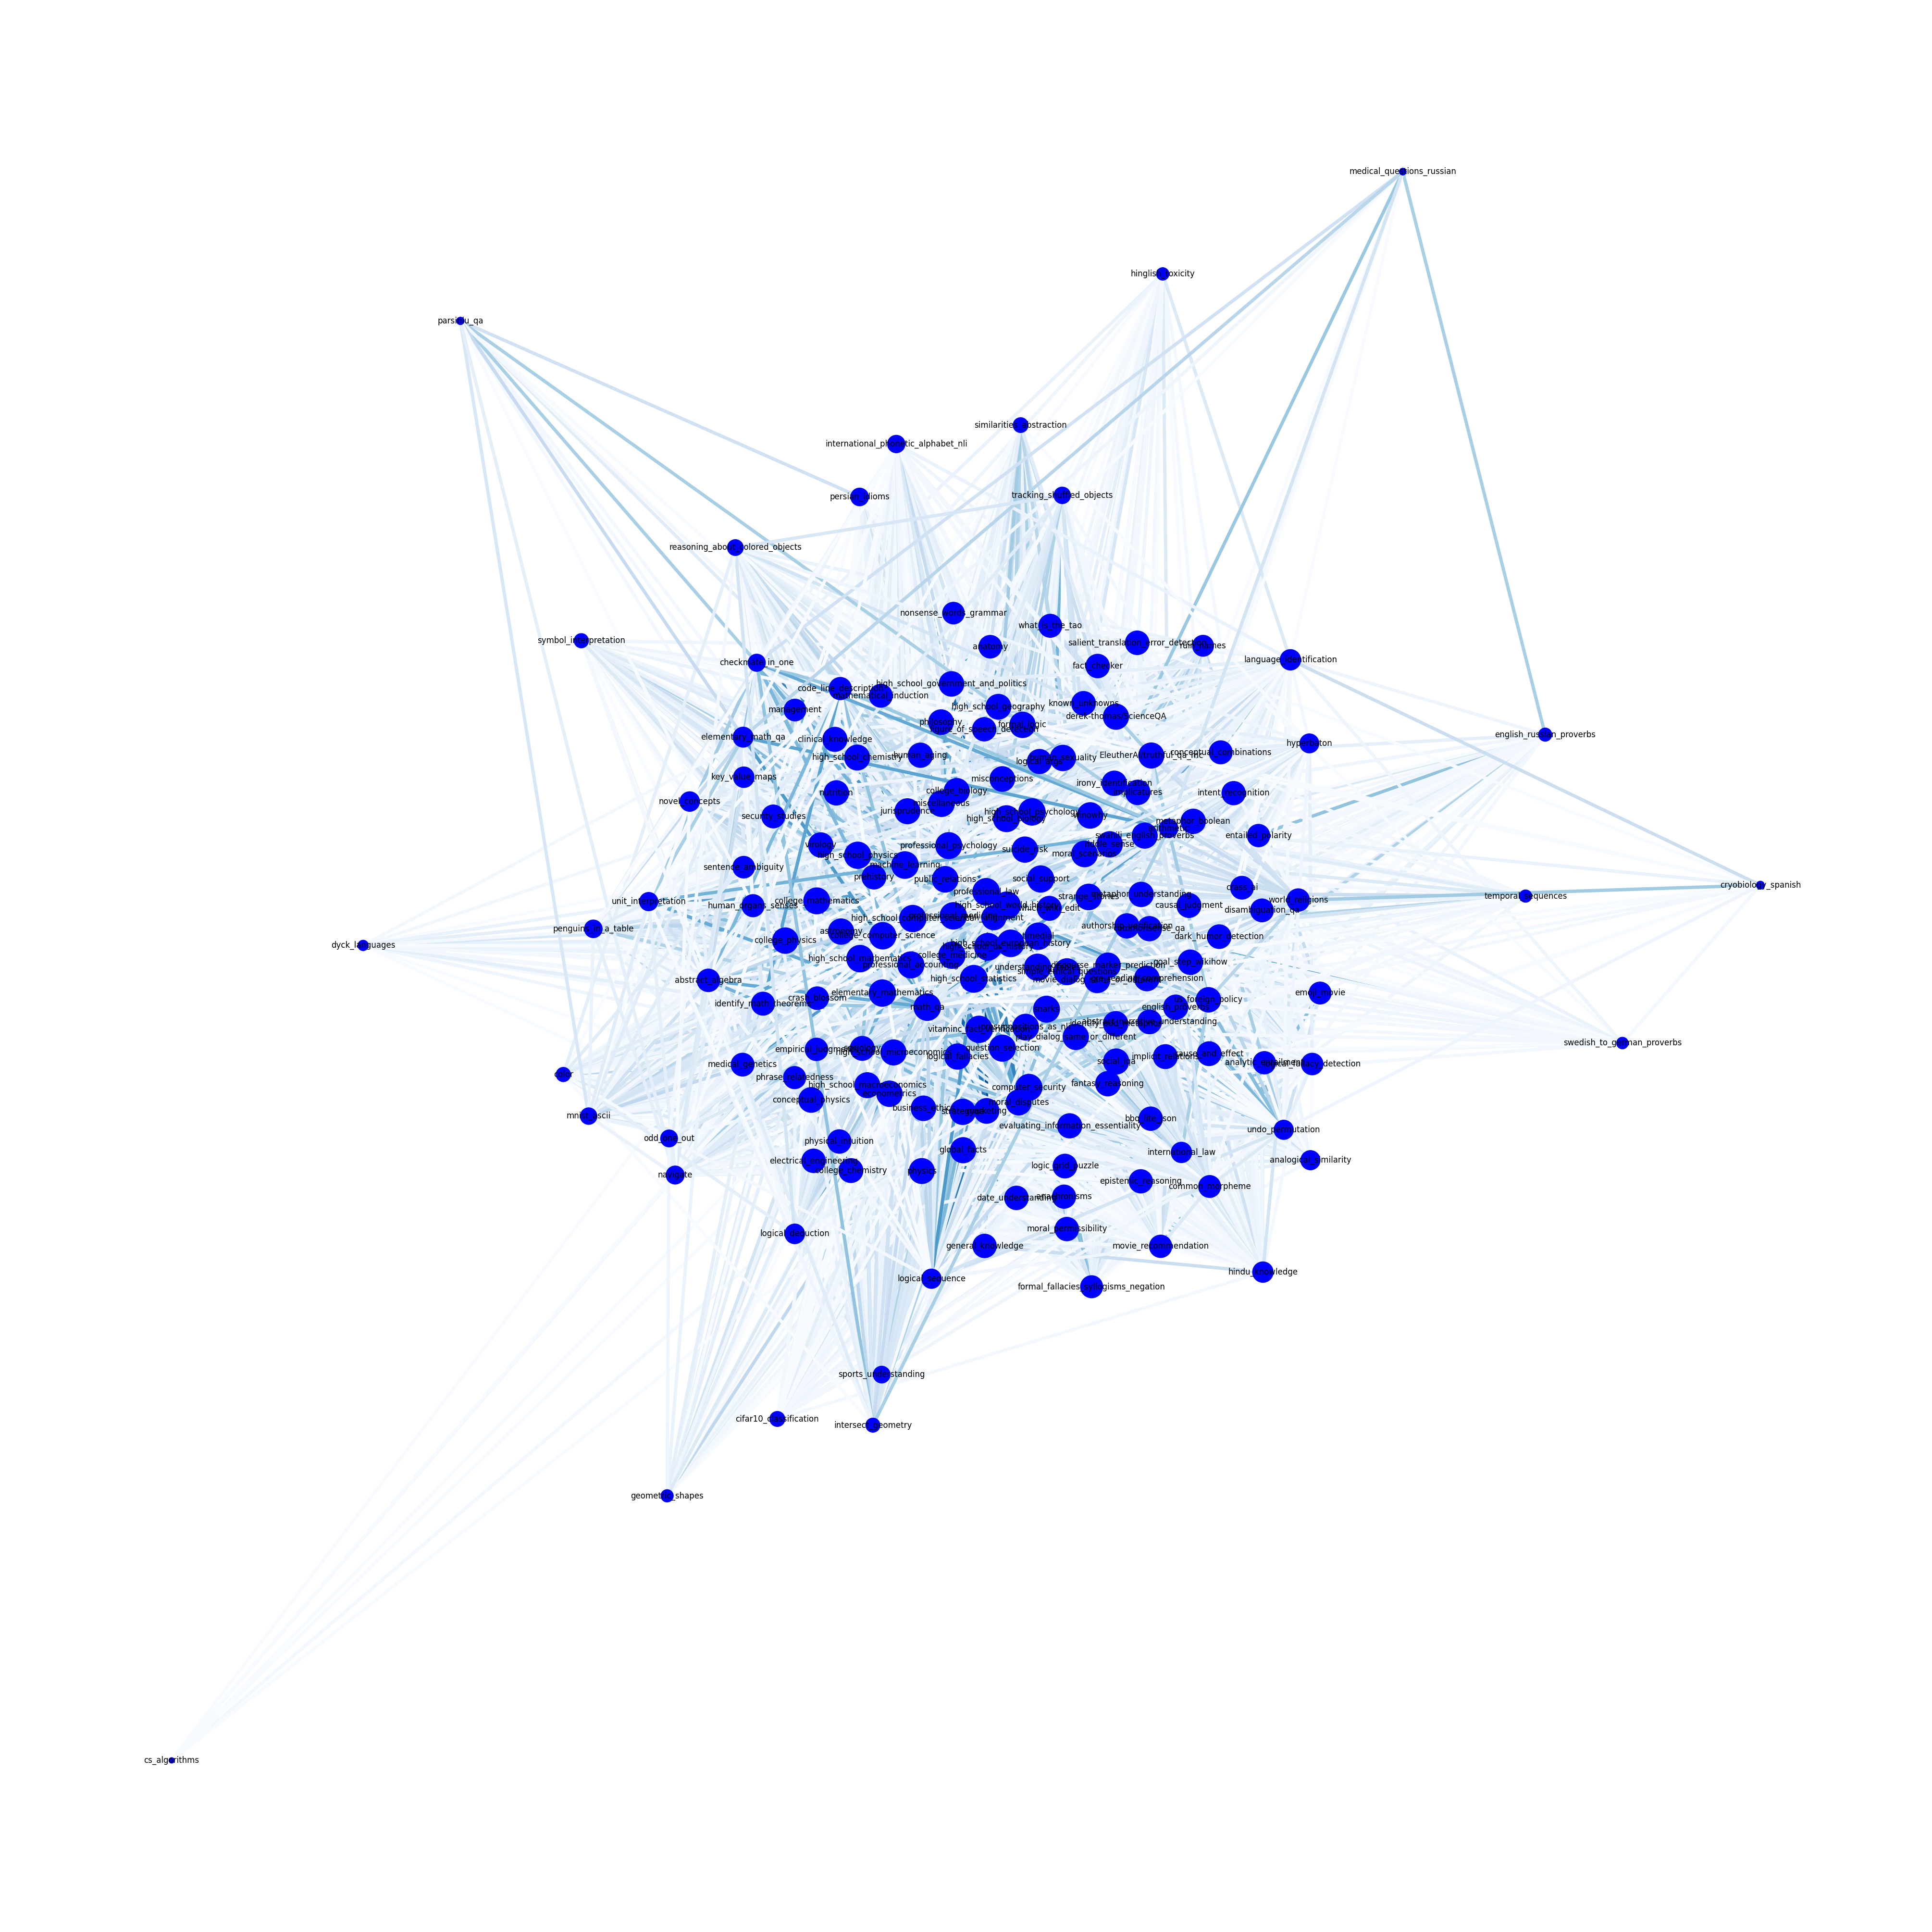

In [100]:
print(G)

plt.figure(figsize=(40, 40), dpi=100)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(G, k=0.8, iterations=20)
d = dict(G.degree)
nx.draw(G, pos, node_color='b',nodelist=d.keys(),node_size=[v * 10 for v in d.values()],with_labels = True, edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues)


## Community Detection

In [101]:
def draw_community(G, communities, community_name):
    # Create a dictionary to map nodes to their community
    community_dict = {}
    for i, comm in enumerate(communities):
        for node in comm:
            community_dict[node] = i

    # Create a list of community memberships for each node
    community_memberships = [community_dict[node] for node in G.nodes()]

    # Plot the graph with nodes colored by community
    #pos = nx.kamada_kawai_layout(G)  # You can use other layout algorithms as well
    pos = nx.spring_layout(G, k=0.8, iterations=20)
    
    plt.figure(figsize=(20, 20), dpi=100)
    nx.draw(G, pos, node_color=community_memberships, with_labels=False, cmap="viridis", width=0.5, node_size=300)

    # Add a colorbar to show the mapping of colors to communities
    plt.title('Community Detection in a Network: '+community_name)
    plt.show()

In [103]:
dict_communities = {}
def dict_label(dict, communities):
    for comm_label, comm in enumerate(communities):
        for nodes in comm:
            if nodes in dict:
                dict[nodes].append(comm_label)
            else:
                dict[nodes]= [comm_label]
    return dict
communities = nx.community.label_propagation_communities(G)
print("label_propagation",len(communities))
dict_communities = dict_label(dict_communities, communities)
#draw_community(G, communities, "label_propagation")
communities = nx.community.greedy_modularity_communities(G)
print("greedy modularity",len(communities))
dict_communities = dict_label(dict_communities, communities)
#draw_community(G, communities, "greedy modularity")
communities = list(nx.community.asyn_lpa_communities(G))
print("asyncronous label propagation",len(communities))
dict_communities = dict_label(dict_communities, communities)

#draw_community(G, communities, "asyncronous label propagation")
communities = nx.community.louvain_communities(G)
print("louvain_communities",len(communities))
dict_communities = dict_label(dict_communities, communities)
#draw_community(G, communities, "louvain_communities")
value = []
for node_name in dict_communities:
    dict_communities[node_name].insert(0, node_name)
    value.append(dict_communities[node_name])

label_propagation 1
greedy modularity 2
asyncronous label propagation 1
louvain_communities 3
